<a href="https://colab.research.google.com/github/nicoelbert/vehicleroutingproblem/blob/main/vehicle_routing_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vehicle Routing Problem
vehicle routing problem on complete information using simmulated annealing

#Preparation

In [11]:
#inital run
if True:
    !pip install networkx
    !pip install pulp
    !pip install plotly
    #!git clone 'https://github.com/nicoelbert/vehicleroutingproblem'
    %cd vehicleroutingproblem


[WinError 2] Das System kann die angegebene Datei nicht finden: 'vehicleroutingproblem'
C:\Users\Nutzer\Documents\GitHub\rrp_simulated_annealing


In [12]:
#import packages
import pandas as pd
import sys
import matplotlib.pyplot as plt
from datetime import datetime
import logging

#custom calsses
#!git pull
from classes import classes as cl
from functions import functions as fc
from functions import routing as rt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#connect drive for exports
#!pip install google
#from google.colab import drive
#drive.mount('/content/drive')
string_exp_path = 'output'


In [13]:
logging.basicConfig(filename="inital_routing_log.log", level=logging.INFO)


In [14]:
#!git pull
#ls()

##Data Import

In [15]:
#depot masterdata
fc.print_log("Starting with Data Import at {}".format(fc.get_time()))



#load Masterdata from csv
url = 'https://raw.githubusercontent.com/nicoelbert/vehicleroutingproblem/main/original_data/Depots.csv'
df_depots = pd.read_csv(url)


#load basetable
url = 'https://raw.githubusercontent.com/nicoelbert/vehicleroutingproblem/main/original_data/preparedJobs.csv'
df_jobs_org = pd.read_csv(url)

#create and fill dict_depots

dict_depots = {}
list_depots = []

for index, row in df_depots.iterrows():
  depot = cl.Depot(row['Werk'],row['Werk_lon'],row['Werk_lat'])
  dict_depots[row['Werk']] = depot
  list_depots.append(depot)


fc.print_log("{} depots created".format(len(dict_depots)))

#create and fill plants from df_jobs_org
dict_plants = {}
list_plants = []

list_plant_names = df_jobs_org['Werk'].unique() 

for pn in list_plant_names:
  row = df_jobs_org[df_jobs_org['Werk'] == pn].iloc[0]
  plant = cl.Plant(row.Werk,row.Werk_lon,row.Werk_lat)
  dict_plants[plant.name] = plant
  list_plants.append(plant)

fc.print_log("{} plants created".format(len(dict_plants)))

#create and fill sites from df_jobs_org

dict_sites = {}
list_sites = []

df_sites = df_jobs_org[['plz','lon','lat']].copy()
df_sites.drop_duplicates(inplace=True)


for index, row in df_sites.iterrows():
  site = cl.Site(row.plz,row.lon,row.lat)
  dict_sites[site.name] = site
  list_sites.append(site)


fc.print_log("{} sites created".format(len(dict_sites)))

#create and fill jobs from df_jobs_org
dict_jobs = {}
list_jobs = []
list_emsen_jobs = []

for index, row in df_jobs_org.iterrows():
  plant = dict_plants[row.Werk]
  site_name = str(row.plz) + '/' +str(row.lon) + '/' + str(row.lat)
  site = dict_sites[site_name]
  prox_depot = rt.get_proxdepot(site,plant,list_depots)
  job = cl.Job(row.id, row.key, plant,row.Maschinentechnik,row.Material,row.Start_clean,(row.Start_clean + row.Werktage), row.Werktage, site, prox_depot )
  dict_jobs[job.name] = job
  list_jobs.append(job)


fc.print_log("{} jobs created".format(len(dict_jobs)))

#create list of days
# since the timespan is 1208 days and there are only 895 relevant days lets work with these first
#create 10 extra days on each bound to avoid key errors

list_days = []
day_ub = 0
day_lb = 999999999

for j in list_jobs: 
  if j.start not in list_days:
    list_days.append(j.start)
  if j.end not in list_days:
    list_days.append(j.end)
    
for day in list_days:
    if day > day_ub:
        day_ub = day
    if day_lb < day_lb: 
        day_lb = day

for i in range(10):
    list_days.append(day_ub+i)
    list_days.append(day_lb-i)


list_days.sort()
fc.print_log("Working with {} relevant days".format(len(list_days)))

#create one tour for each day and depot

dict_tours = {}
total_tours_created = 0

for depot in dict_depots:
  dict_tours[depot] = {}

for depot in list_depots:
  for day in list_days:
    dict_tours[depot.name][day] = cl.Tour(depot,day)
  total_tours_created += len(dict_tours[depot.name])

fc.print_log("{} tours created".format(total_tours_created))

#define dict of objects for persistation
persistation_objects = {}
persistation_objects['dict_depots'] = dict_depots
persistation_objects['dict_sites'] = dict_sites
persistation_objects['dict_plants'] = dict_plants
persistation_objects['dict_jobs'] = dict_jobs
persistation_objects['dict_tours'] = dict_tours
persistation_objects['list_days'] = list_days

    
fc.print_log("Done with Data Import at {}".format(fc.get_time()))

Starting with Data Import at 21:43:53
15 depots created
8 plants created
6166 sites created
53178 jobs created
Working with 915 relevant days
13710 tours created
Done with Data Import at 21:44:07


Visualize Data


C:\Users\Nutzer\Documents\GitHub\rrp_simulated_annealing\functions\functions.py:42: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



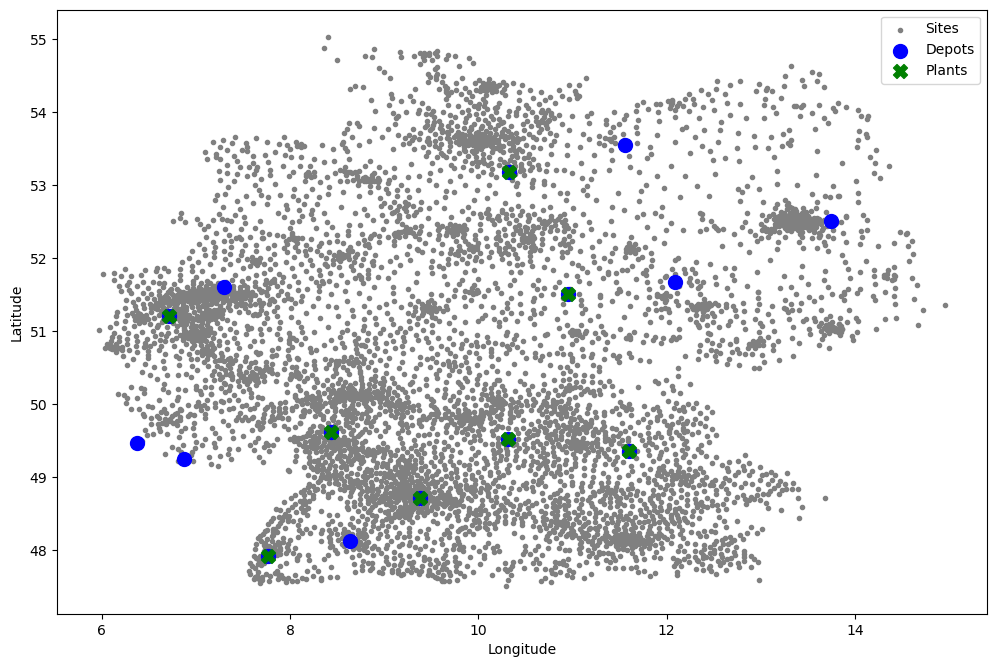

In [16]:
fc.get_map(list_depots,list_plants,list_sites)

Inital Solution

In [17]:
#create inital solution
""" every silo is delivered on the day it is needed and picked up the day it is not needed anymore, the tour swichtes between plant and sites - starting and ending at the depot"""

fc.print_log("Starting with inital solution at {}".format(fc.get_time()))

#assign start and end day as dropoff and pickup day +/-1 one 
for j in list_jobs:
  j.dropoff_day = fc.day_navigation(j.start,1,list_days) #-1
  j.pickup_day = fc.day_navigation(j.end,0,list_days) #+1
  j.dropoff_depot = j.prox_depot
  j.pickup_depot = j.prox_depot

  #assign inital tours
  j.dropoff_tour = dict_tours[j.dropoff_depot.name][j.dropoff_day]
  j.pickup_tour = dict_tours[j.pickup_depot.name][j.pickup_day]

  #insert jobs and plants into tours for dropoff and pickup
  if j not in j.dropoff_tour.list_dropoffs:
    j.dropoff_tour.list_dropoffs.append(j)
  if j.plant not in j.dropoff_tour.list_plants:
    j.dropoff_tour.list_plants.append(j.plant)
  
  if j not in j.pickup_tour.list_pickups:
    j.pickup_tour.list_pickups.append(j)
  if j.plant not in j.pickup_tour.list_plants:
    j.pickup_tour.list_plants.append(j.plant)
  

i_pickups = 0
i_dropoffs = 0
i_multiple_plants = 0


######################################################################################################
#count the number of pickups and dropoffs and write into the tours, also detect multiple plants 
for depot in dict_depots:
  for day in list_days:
    
   i_pickups = i_pickups + len(dict_tours[depot][day].list_pickups)
   i_dropoffs = i_dropoffs + len(dict_tours[depot][day].list_dropoffs)
   dict_tours[depot][day].total_pickups = len(dict_tours[depot][day].list_pickups)
   dict_tours[depot][day].total_dropoffs = len(dict_tours[depot][day].list_dropoffs) 
   dict_tours[depot][day].total_tasks =  dict_tours[depot][day].total_pickups + dict_tours[depot][day].total_dropoffs 
    
   if len(dict_tours[depot][day].list_plants) > 1:
     i_multiple_plants = i_multiple_plants + 1
     fc.print_log("Warning at Tour from {} and day {} - {} plants listed".format(depot,day,len(dict_tours[depot][day].list_plants)))
     p_names = []
     for p in dict_tours[depot][day].list_plants:
       p_names.append(p.name)
     print(p_names)


        
######################################################################################################
#reassign to fit max tours constrai

#not set to max tour size too leave room for local moves
max_inital_toursize = 100
#run as long as max value is exceeded
max_exceeded = True
#log iteration
i_loop_iteration = 0
total_reassignments = 0

fc.print_log("Starting reassignmentat {}".format(fc.get_time()))

while max_exceeded:
    i_loop_iteration += 1 
    max_exceeded = False
    for depot in dict_depots:
      for tour_day in list_days:
        if dict_tours[depot][tour_day].total_tasks > max_inital_toursize:
            if dict_tours[depot][tour_day].total_tasks > max_overflow:
                max_exceeded = True
                #get difference between max value and tour
                difference = dict_tours[depot][tour_day].total_tasks - max_inital_toursize

                #define pickups and dropoffs to be moved to another tour
                list_moveable_pickups = []
                list_moveable_dropoffs = []
                #later the worst elements should be moved(when the routing is done, now it doesnt matter)
                #while selecting tasks, flatten out pickups and dropoff difference
                print("iteration: {} difference: {}, total_tasks: {}, day: {}, depot: {} ".format(i_loop_iteration,difference,dict_tours[depot][tour_day].total_tasks,tour_day,depot))
                for iteration in range(difference):
                    if dict_tours[depot][tour_day].total_dropoffs > dict_tours[depot][tour_day].total_pickups:
                        #pop the first task, so appended don't get handed down
                        list_moveable_pickups.append(dict_tours[depot][tour_day].list_dropoffs.pop(0))
                    else: #else, bc if equal it doesn't matter and pickup can be popped
                        list_moveable_pickups.append(dict_tours[depot][tour_day].list_pickups.pop(0))  

                dict_tours[depot][tour_day].update_totals()
                #now assign all tasks to the next tour - this might create another overflow, but keeps 
                #the tasks as close to the original date as possible

                #days are can not just be added or substracted so the index is determined
                tour_day_index = list_days.index(tour_day)

                #move dropoffs to tour before:    
                for task in list_moveable_dropoffs:
                    #read the day before from the days list and append entry
                    day_before = list_days[tour_day_index-1]
                    dict_tours[depot][day_before].list_dropoffs.append(task)
                    dict_tours[depot][day_before].update_totals()


                #move pickups to tour after:    
                for task in list_moveable_pickups:
                    #read the day before from the days list and append entry
                    day_after = list_days[tour_day_index+1]
                    dict_tours[depot][day_after].list_dropoffs.append(task)
                    dict_tours[depot][day_after].update_totals()

                total_reassignments += (len(list_moveable_dropoffs)+len(list_moveable_pickups))       

        
    
fc.print_log("Done with reassignment at {} - {} tasks reassigned".format(fc.get_time(),total_reassignments))        

######################################################################################################


#calculate the routing for the created inital solution
total_tours = 0
used_tours = 0
total_distance = 0
sys.setrecursionlimit(100000) # for export

for depot in dict_depots:
  for day in list_days:
    if len(dict_tours[depot][day].list_plants)>0:
      rt.routing(dict_tours[depot][day])
      fc.print_log("Distance for depot {} on day {} is {} - {}/{}  done - {} filled - total distance: {} - {} plant(s) detected - t: {}".format(depot,day,dict_tours[depot][day].distance,total_tours,total_tours_created,used_tours,total_distance,len(dict_tours[depot][day].list_plants),fc.get_time()), overwrite_inline = True)
      total_distance += dict_tours[depot][day].distance
      used_tours += 1  
    for i in range(30):
        if total_tours == i*500:
            #quicksave all data objects every 500 iterations
            fc.quick_save(persistation_objects,string_exp_path,total_tours)
    total_tours += 1
  
print("")
fc.print_log("There are {} dropoffs and {} pickups listet which creates a difference of {}".format(i_dropoffs,i_pickups,i_dropoffs-i_pickups))
fc.print_log("Done with inital solution at {} - total distance: {} - for {} total tours and {} filled".format(fc.get_time(),total_distance, total_tours, used_tours)) 

Starting with inital solution at 21:44:07
Warning at Tour from Neuherberg and day 16883 - 2 plants listed
['Lauterhofen', 'Neuherberg']
Warning at Tour from Neuherberg and day 16900 - 2 plants listed
['Lauterhofen', 'Neuherberg']
Warning at Tour from Embsen and day 17032 - 2 plants listed
['Embsen', 'Rottleberode']
Warning at Tour from Embsen and day 17042 - 2 plants listed
['Embsen', 'Rottleberode']
Starting reassignmentat 21:44:08
Done with reassignment at 21:44:08 - 0 tasks reassigned
Starting quicksave at 21:44:08
Done with persitation at 21:44:08
[1KDistance for depot Neuherberg on day 16736 is 4445.789419847686 - 96/13710  done - 59 filled - total distance: 137047.04606775788 - 1 plant(s) detected - t: 21:44:09Distance for depot Neuherberg on day 16741 is 4941.164613907655 - 101/13710  done - 64 filled - total distance: 165360.99873491345 - 1 plant(s) detected - t: 21:44:09Distance for depot Neuherberg on day 16744 is 8396.637399975953 - 104/13710  done - 67 filled - total distan

Persitate Inital Solution

In [18]:
fc.persistate(persistation_objects,string_exp_path,'final')


Starting persitation at 21:47:28
Done with persitation at 21:47:29


In [19]:
test_tour  = dict_tours['Neuherberg'][17042]

rt.routing(test_tour)
fc.visualize_tour(test_tour)


##Backup

In [20]:
#backup

"""
get runtime for testdays:

fc.print_log("Starting at {}".format(fc.get_time()))

test_days = [16736,16753,16755,16793,16796,16929,16941,16945,16951,16999,17010,17078,17087,17163,17181]

depot = 'Neuherberg'

for d in test_days: 
    fc.print_log("Starting 31- {} at {}".format(d,fc.get_time()))
    rt.routing(dict_tours[depot][d])
    print(dict_tours[depot][d].distance)
    
fc.print_log("Done at{}".format(fc.get_time()))
    
"""

'\nget runtime for testdays:\n\nfc.print_log("Starting at {}".format(fc.get_time()))\n\ntest_days = [16736,16753,16755,16793,16796,16929,16941,16945,16951,16999,17010,17078,17087,17163,17181]\n\ndepot = \'Neuherberg\'\n\nfor d in test_days: \n    fc.print_log("Starting 31- {} at {}".format(d,fc.get_time()))\n    rt.routing(dict_tours[depot][d])\n    print(dict_tours[depot][d].distance)\n    \nfc.print_log("Done at{}".format(fc.get_time()))\n    \n'